In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import re
import astropy.units as u

from tqdm import tqdm_notebook as tqdm
from scipy import signal
import arepo

from numpy.polynomial import Polynomial

from scipy.stats import linregress

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5', 'Nbody300-BH', 'Nbody500-BH1E8']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/analysis/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f



In [4]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier, debug=False):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
        if debug:
            print(tlist[i], fourier[key]['Rlist'][np.argmax(A2/A0)], np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [5]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar anglea
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin, cum=False):
    if cum:
        rk = 'A2r_c'
        ri = 'A2i_c'
    else:
        rk = 'A2r'
        ri = 'A2i'
    
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k][rk]) for k in keys])
    A2i = np.array([np.array(dat[k][ri]) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def main_bar_angle(dat, Rbin = 3, firstkey = 150, nmax = 10, cum=False):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin, cum=cum)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [6]:
fourier = read_fourier(0, lvl='lvl3')
out = main_bar_angle(fourier, Rbin=3, firstkey=0, cum=True)

fourierBH = read_fourier(2, lvl='lvl3')
outBH = main_bar_angle(fourierBH, Rbin=3, firstkey=0, cum=True)

fourierBH1E8 = read_fourier(3, lvl='lvl3')
outBH1E8 = main_bar_angle(fourierBH1E8, Rbin=3, firstkey=0, cum=True)

<ipython-input-5-db31fcbdb6e4>:111: RuntimeWarning: divide by zero encountered in reciprocal
  ps = (n-i) * pfit_n[i] * time**(n-1-i)
<ipython-input-5-db31fcbdb6e4>:111: RuntimeWarning: invalid value encountered in multiply
  ps = (n-i) * pfit_n[i] * time**(n-1-i)


(0.0, 8.0)

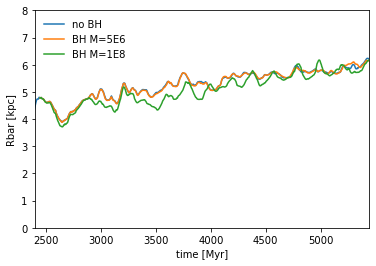

In [18]:
plt.plot(out['time'], out['Rbar'], label='no BH')
plt.plot(outBH['time']+out['time'][500], outBH['Rbar'], label='BH M=5E6')
plt.plot(outBH1E8['time']+out['time'][500], outBH1E8['Rbar'], label='BH M=1E8')
plt.legend(frameon=False)
plt.xlim(out['time'][500]-50, out['time'][500] + 3000)
plt.xlabel('time [Myr]')
plt.ylabel('Rbar [kpc]')
plt.ylim(0, 8)

In [70]:
len(outBH1E8['time'])

75

(0.0, 6.0)

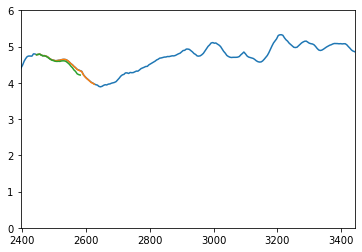

In [65]:
plt.plot(out['time'], out['Rbar'])
plt.plot(outBH['time']+out['time'][500], outBH['Rbar'])
plt.plot(outBH1E8['time']+out['time'][500], outBH1E8['Rbar'])
plt.xlim(out['time'][500]-50, out['time'][500] + 1000)
plt.ylim(0, 6)

(0.0, 60.0)

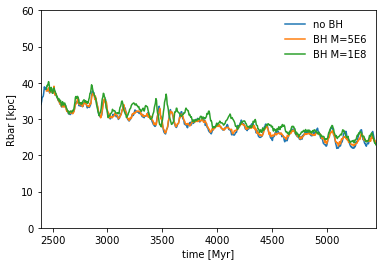

In [21]:
plt.plot(out['time'], out['pattern_speed'], label='no BH')
plt.plot(outBH['time']+out['time'][500], outBH['pattern_speed'], label='BH M=5E6')
plt.plot(outBH1E8['time']+out['time'][500], outBH1E8['pattern_speed'], label='BH M=1E8')
plt.legend(frameon=False)
plt.xlim(out['time'][500]-50, out['time'][500] + 3000)
plt.xlabel('time [Myr]')
plt.ylabel('Rbar [kpc]')
plt.ylim(0, 60)

In [26]:
outBH.keys()

dict_keys(['time', 'firstkey', 'R', 'Rbar', 'phi', 'bar_angle', 'pattern_speed', 'pfit', 'poly_eval'])

In [11]:
sn = read_snap(75, 3, lvl='lvl3', parttype=None)

In [15]:
sn.MassTable[5] / (sn.MassTable[3] * sn.NumPart_Total[3])*100

1.24133047 

In [51]:
100 * (1E8/1E10) / (sn.MassTable[2] * sn.NumPart_Total[2])

0.20688841 None